Dataset Used: German Traffic Sign Recognition Benchmark
(GTSRB)

Structure: Conv2D(32) -> Activation -> BatchNorm -> MaxPool2D(16) -> FC -> FC -> Softmax

 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Kaggle Config**

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle  

In [0]:
import json
token = {"username":"rajatsahay","key":"xxxxxxxxxxxxxxxx"}
with open('/content/drive/My Drive/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!cp /content/drive/My\ Drive/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /content/drive/My\ Drive/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16          18126  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          3MB  2019-07-05 09:58:02          12764  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16          14189  
chirin/africa-economic-banking-and-systemic-crisis-data  Africa Economic, Banking and Systemic Crisis Data   14KB  2019-07-21 02:00:17           6535  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data     

In [0]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign 

100% 611M/612M [00:04<00:00, 127MB/s]
100% 612M/612M [00:04<00:00, 141MB/s]


In [0]:
ls

gtsrb-german-traffic-sign.zip


**Model**

In [59]:
#MODEL
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation,Flatten,Dropout,Dense

class TrafficSignNet:
  @staticmethod
  def build(width,height,depth,classes):
    model=Sequential()
    inputShape=(height,width,depth)
    ChanDim=-1

    #Conv2D->Relu->BatchNorm->MaxPool

    ## size=32x32 ##
    model.add(Conv2D(8,(5,5),padding="same",input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=ChanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    ## size=16x16 ##

    #first set (Conv->ReLU->Conv->ReLU)*2->MaxPool
    model.add(Conv2D(16,(3,3),padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=ChanDim))
    model.add(Conv2D(16,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=ChanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))

    ## size=3x3 ##

    #second set (Conv->ReLU->Conv->ReLU)*2->MaxPool
    model.add(Conv2D(32,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=ChanDim))
    model.add(Conv2D(32,(3,3),padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=ChanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))

    #Two sets of FC and softmax classifier
    
    #first set
    model.add(Flatten())
    #model=Flatten()(model)
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    '''
    #second set
    model.add(Flatten())
    #model=Flatten()(model)
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    '''
    #softmax
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


In [11]:
import matplotlib
matplotlib.use('Agg')
%matplotlib notebook

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
#from sklearn.metrics import classification_report
from skimage import transform,exposure,io
import matplotlib.pyplot as plt
import numpy as np
import random
import os

#keras patch: ImageDataGenerator is now in keras.preprocessing.image

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


In [65]:
import cv2
def load_split(basePath,csvPath):
  #data,labels
  data=[]
  labels=[]

  #load contenst of .csv file, remove header (top line) and shuffle contents
  rows=open(csvPath).read().strip().split("\n")[1:]
  random.shuffle(rows)

  #loop over rows
  for (i,row) in enumerate(rows):
    if i>0 and i%1000==0:
      print("Processed {} images".format(i))

    #split to get class ID and img path
    (label,imagePath)=row.strip().split(",")[-2:]
    imagePath=os.path.sep.join([basePath,imagePath])

    image=cv2.imread(imagePath) #io

    #use CLAHE to improve contrast of images (https://imagej.net/Enhance_Local_Contrast_(CLAHE))
    #resize img to 32x32 pixels ignoring aspect ratio and perform CLAHE

    image=transform.resize(image,(32,32))
    image=exposure.equalize_adapthist(image, clip_limit=0.1)
    
    data.append(image)
    labels.append(int(label))

  data=np.array(data)
  labels=np.array(labels)

  return (data,labels)

In [66]:
#PreReq
num_epochs=30
init_lr=1e-3 #learning rate
bs=64 #batch size

labelNames=open("D:\Research\German Traffic Research Benchmark\signnames.csv").read().strip().split("\n")[1:]
labelNames=[l.split(",")[1] for l in labelNames]


#TODO

path_to_model="D:\Research\German Traffic Research Benchmark"
path_to_Traindataset="D:\Research\German Traffic Research Benchmark"
path_to_Testdataset="D:\Research\German Traffic Research Benchmark"

'''
path_to_model="/content/drive/My Drive/{/content}/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
path_to_Traindataset="/content/drive/My Drive/{/content}/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
path_to_Testdataset="/content/drive/My Drive/{/content}/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
'''

trainPath=os.path.sep.join([path_to_Traindataset,"Train.csv"])
testPath=os.path.sep.join([path_to_Testdataset,"Test.csv"])

#load training and testing data
print("Loading Training and Testing Data")
(trainX,trainY)=load_split(path_to_Traindataset,trainPath)
(testX,testY)=load_split(path_to_Testdataset,testPath)

#scale data to range [0.1]
trainX=trainX.astype("float32")/255.0
testX=testX.astype("float32")/255.0

#one-hot encode labels
numLabels=len(np.unique(trainY))
trainY=to_categorical(trainY,numLabels)
testY=to_categorical(testY,numLabels)

#account for skew in labelled data
classTotals=trainY.sum(axis=0)
classWeight=classTotals.max()/classTotals


Loading Training and Testing Data


D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processed 18000 images
Processed 19000 images
Processed 20000 images
Processed 21000 images
Processed 22000 images
Processed 23000 images
Processed 24000 images
Processed 25000 images
Processed 26000 images
Processed 27000 images
Processed 28000 images
Processed 29000 images
Processed 30000 images
Processed 31000 images
Processed 32000 images
Processed 33000 images
Processed 34000 images
Processed 35000 images
Processed 36000 images
Processed 37000 images
Processed 38000 images
Processed 39000 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Pr

In [67]:
#Image data generator for data augmentation
aug=ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"   
)

#initialize optimizer and compile model
print("Compiling Model")
opt=Adam(lr=init_lr,decay=init_lr/(num_epochs*0.5))
model=TrafficSignNet.build(width=32,height=32,depth=3,classes=numLabels)


model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

#Train
print("Training Network")
H=model.fit_generator(
    aug.flow(trainX,trainY,batch_size=bs),
    validation_data=(testX,testY),
    steps_per_epoch=trainX.shape[0]//bs,
    epochs=num_epochs,
    class_weight=classWeight,
    verbose=1
)



Compiling Model
Training Network
Epoch 1/30
612/612 [==============================] - 33s 54ms/step - loss: 1.9736 - acc: 0.4628 - val_loss: 0.9679 - val_acc: 0.6997
Epoch 2/30
612/612 [==============================] - 15s 25ms/step - loss: 0.7991 - acc: 0.7516 - val_loss: 0.7574 - val_acc: 0.7532
Epoch 3/30
612/612 [==============================] - 15s 24ms/step - loss: 0.5078 - acc: 0.8417 - val_loss: 0.4111 - val_acc: 0.8713
Epoch 4/30
612/612 [==============================] - 15s 25ms/step - loss: 0.3876 - acc: 0.8777 - val_loss: 0.2730 - val_acc: 0.9169
Epoch 5/30
612/612 [==============================] - 15s 25ms/step - loss: 0.2950 - acc: 0.9057 - val_loss: 0.2828 - val_acc: 0.9135
Epoch 6/30
612/612 [==============================] - 15s 24ms/step - loss: 0.2579 - acc: 0.9182 - val_loss: 0.2803 - val_acc: 0.9131
Epoch 7/30
612/612 [==============================] - 16s 26ms/step - loss: 0.2190 - acc: 0.9307 - val_loss: 0.2934 - val_acc: 0.9131
Epoch 8/30
612/612 [=========

In [69]:
from sklearn.metrics import classification_report
#Evaluate network
path_to_model="D:\Research\German Traffic Research Benchmark\model.h5"
predictions=model.predict(testX,batch_size=bs)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1),target_names=labelNames))

model.save(path_to_model)

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.75      1.00      0.86        60
                              Speed limit (30km/h)       0.97      0.98      0.98       720
                              Speed limit (50km/h)       0.97      0.98      0.97       750
                              Speed limit (60km/h)       0.95      0.97      0.96       450
                              Speed limit (70km/h)       0.99      0.96      0.97       660
                              Speed limit (80km/h)       0.97      0.95      0.96       630
                       End of speed limit (80km/h)       0.88      0.99      0.93       150
                             Speed limit (100km/h)       0.99      0.94      0.97       450
                             Speed limit (120km/h)       0.95      0.98      0.97       450
                                        No passing       0.99      0.98      0.

<IPython.core.display.Javascript object>


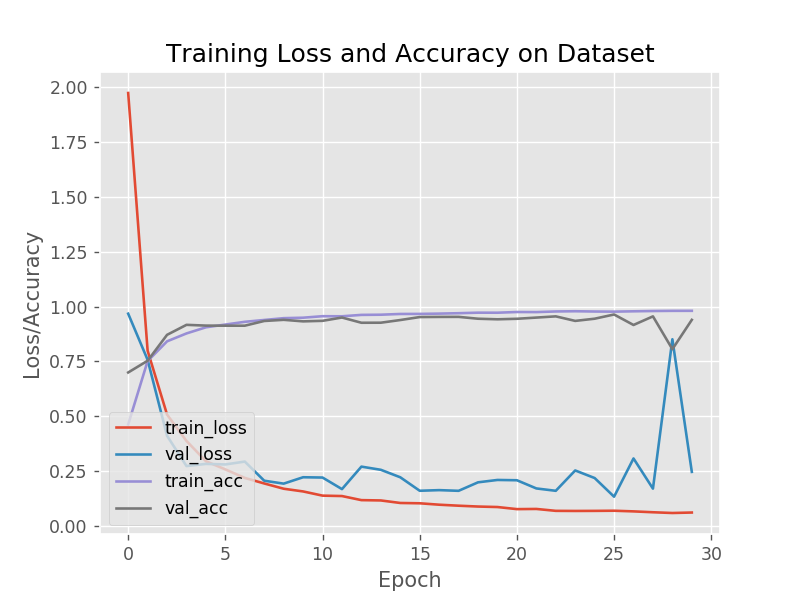

In [74]:
#plot training loss and accuracy
N=np.arange(0,num_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N,H.history["loss"],label="train_loss")
plt.plot(N, H.history["val_loss"],label="val_loss")
plt.plot(N, H.history["acc"],label="train_acc")
plt.plot(N, H.history["val_acc"],label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

<b> <h4> NOTE: For TensorfFlow 2.0 and above: </h4><br>
    H.History["acc"] would become H.History["accuracy"] <br>
    H.History["val_acc"] would become H.History["val_accuracy"]

In [102]:
#preds
from keras.models import load_model
import cv2

model=load_model(path_to_model)
labelNames=open("D:\Research\German Traffic Research Benchmark\signnames.csv").read().strip().split("\n")[1:]
labelNames=[l.split(",")[1] for l in labelNames]

print("Predicting")
imagePaths=os.listdir("D:\Research\German Traffic Research Benchmark\Test")
#random.shuffle(imagePaths)
imagePaths=imagePaths[:25]
for (i,imagePath) in enumerate(imagePaths):
    image=cv2.imread("D:\\Research\\German Traffic Research Benchmark\\Test\\"+imagePath)
    image=transform.resize(image, (32, 32))
    image=exposure.equalize_adapthist(image, clip_limit=0.1)
 #preprocess image by scaling it to the range [0, 1]
    image=image.astype("float32") / 255.0
    image=np.expand_dims(image, axis=0)
 #make predictions using the traffic sign recognizer CNN
    preds=model.predict(image)
    j=preds.argmax(axis=1)[0]
    label=labelNames[j]
 #load the image using OpenCV, resize it, and draw the label
    image=cv2.imread("D:\\Research\\German Traffic Research Benchmark\\Test\\"+imagePath)
    height=image.shape[0]
    width=128
    dim=(width,height)
    image=cv2.resize(image,dim,interpolation=cv2.INTER_AREA)
    #image=imutils.resize(image, width=128)
    cv2.putText(image, label,(5,15),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,0,255),2)
    
    path_to_examples="D:\Research\German Traffic Research Benchmark\Examples"
    p = os.path.sep.join(["path_to_examples", "{}.png".format(i)])
    cv2.imwrite(p, image)


Predicting


D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Anaconda\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
open("signnames.csv")

<_io.TextIOWrapper name='signnames.csv' mode='r' encoding='UTF-8'>

In [64]:
print(data)

NameError: name 'data' is not defined

In [96]:
imagePaths=os.listdir("D:\Research\German Traffic Research Benchmark\Test")
imagePaths=imagePaths[:25]
#print(imagePaths)
for (i,imagePath) in enumerate(imagePaths):
    cv2.imread("D:\\Research\\German Traffic Research Benchmark\\Test\\"+imagePath)